<a href="https://colab.research.google.com/github/mohadeseh-ghafoori/Generative-AI/blob/main/Wasserstein_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Wasserstein Distance as Loss Function
Let's break down how the Wasserstein distance encourages diversity in the generated samples:

Understanding Wasserstein Distance:
The Wasserstein distance (also known as Earth Mover's Distance) measures the minimum amount of work required to transform one probability distribution into another. In the context of GANs, it quantifies how dissimilar the distribution of generated samples is from the true data distribution.

Encouraging Diversity:
When optimizing the Wasserstein distance, the generator aims to minimize the discrepancy between the generated samples' distribution and the true data distribution. To achieve this, the generator needs to cover as much of the data distribution as possible, including its various modes and patterns.

Capturing Different Modes:
Each mode in the data distribution corresponds to a distinct pattern or characteristic in the data. By minimizing the Wasserstein distance, the generator is incentivized to produce samples that capture these different modes accurately. Failing to cover all modes would result in a higher Wasserstein distance, indicating poor alignment with the true data distribution.

Balancing Exploration and Exploitation:
To minimize the Wasserstein distance effectively, the generator needs to balance exploration (discovering new modes) and exploitation (improving the quality of generated samples). This balance ensures that the generator does not focus solely on the dominant modes but also explores and represents the less frequent modes in the data distribution.

Stable Optimization:
Unlike other distance metrics, such as the Jensen-Shannon divergence used in traditional GANs, the Wasserstein distance provides smoother gradients and more stable optimization. This stability allows the generator to explore the entire data distribution more effectively, contributing to the generation of diverse samples.

In summary, the nature of the Wasserstein distance as a measure of dissimilarity between distributions inherently encourages the generator to produce diverse samples by minimizing the discrepancy between the generated distribution and the true data distribution, thereby capturing different modes and patterns in the data.

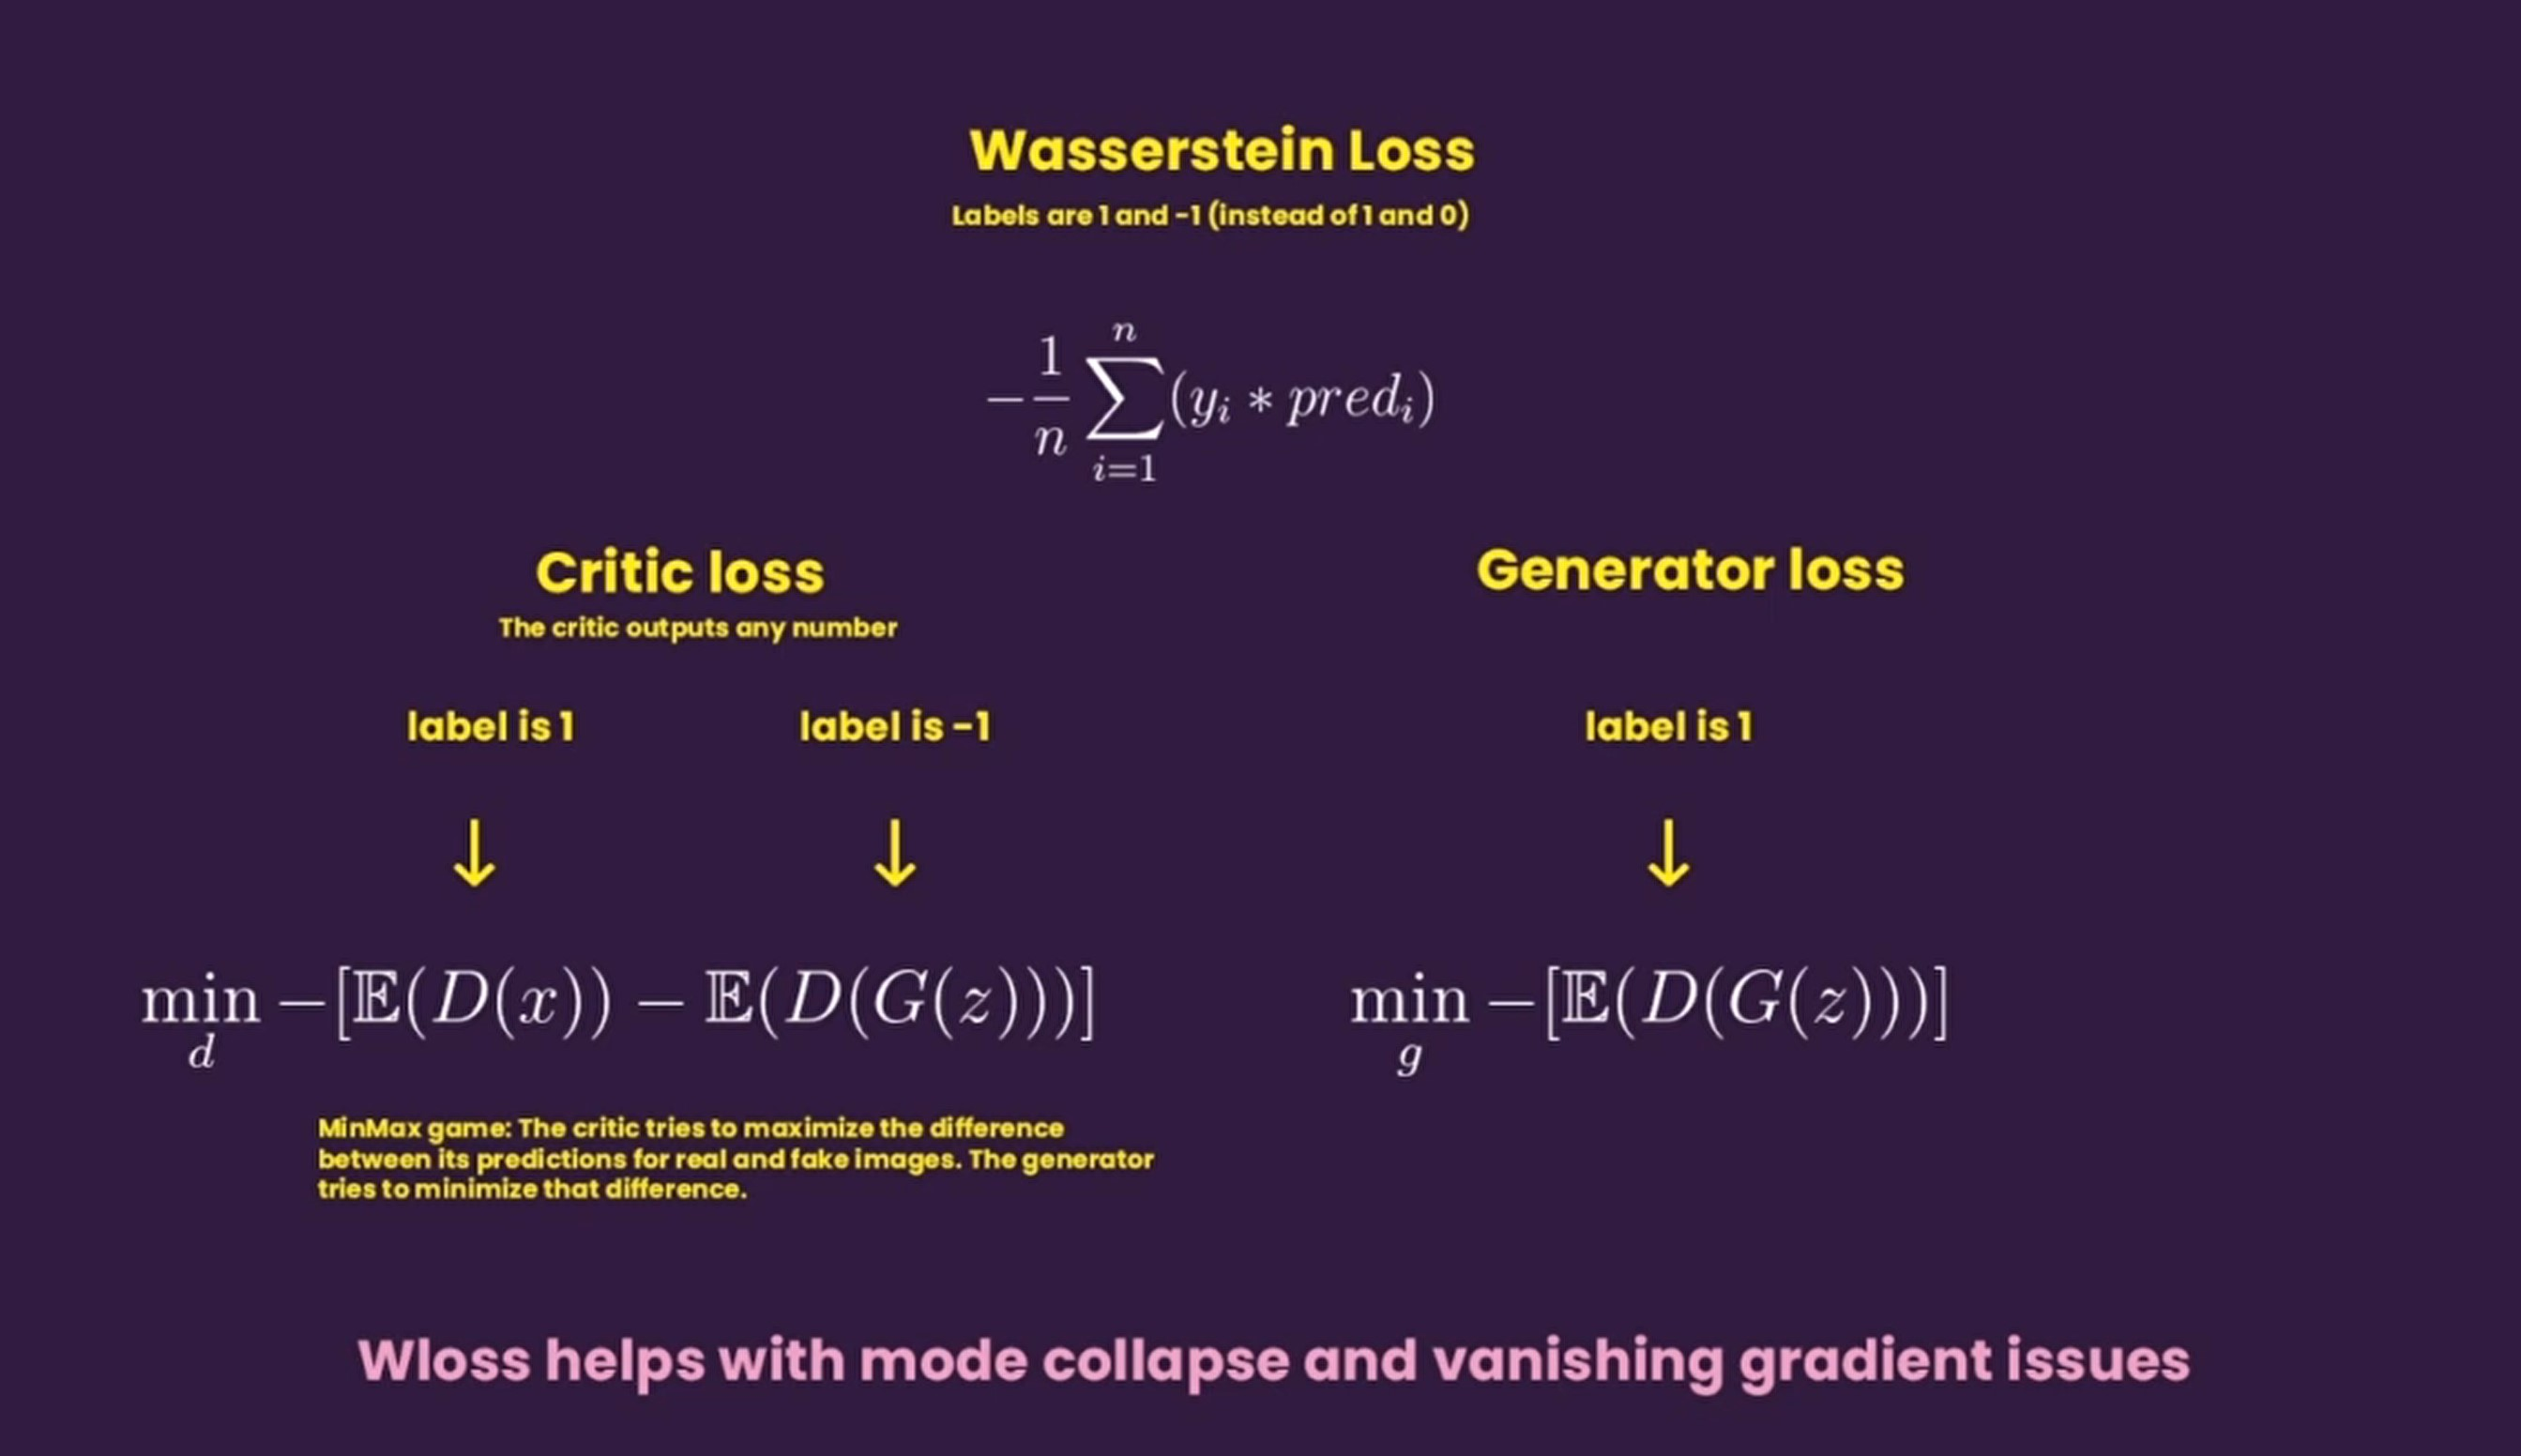

In [ ]:
import torch, os, torchvision, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def show(tensor, num=25, name=''):
  data = tensor.detach().cpu()
  grid = make_grid(data[:num],nrow=5).permute(1,2,0)
  plt.imshow(grid.clip(0,1))
  plt.show()


#hyperparameters
epochs=50
batch_size=128
lr=1e-4
z_dim=200
device='cuda' #GPU

cur_step=0
crit_cycles=5
gen_losses=[]
crit_losses=[]
show_step=500
save_step=500

In [ ]:
#Generator
class Generator(nn.Module):
  def __init__(self, z_dim=64,d_dim=16):
    super().__init__()
    self.gen = nn.Sequential(
            ## ConvTranspose2d: in_channels, out_channels, kernel_size, stride=1, padding=0
            ## Calculating new width and height: (n-1)*stride -2*padding +ks
            ## n = width or height
            ## ks = kernel size
            ## we begin with a 1x1 image with z_dim number of channels (200)
        nn.ConvTranspose2d(z_dim,d_dim*32,4,1,0), # input image : 1*1*z_dim(200) >> output image: 4*4*d_dim*32(512)
        nn.BatchNorm2d(d_dim*32),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*32,d_dim*16,4, 2, 1), # input image : 4*4*d_dim*32 >> output image: 8*8*d_dim*16(256)
        nn.BatchNorm2d(d_dim*16),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*16,d_dim*8,4, 2, 1), # input image : 8*8*d_dim*16(256) >> output image: 16*16*d_dim*8(128)
        nn.BatchNorm2d(d_dim*8),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*8,d_dim*4,4, 2, 1), # input image : 16*16*d_dim*8(128) >> output image: 32*32*d_dim*4(64)
        nn.BatchNorm2d(d_dim*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*4,d_dim*2,4, 2, 1), # input image : 32*32*d_dim*4(64) >> output image: 64*64*d_dim*2(32)
        nn.BatchNorm2d(d_dim*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*2,3,4, 2, 1), # input image : 64*64*d_dim*2(32) >> output image: 128*128*3
        nn.BatchNorm2d(3),
        nn.ReLU(True),
    )

  def forward(self, noise):
    x = noise.view(len(noise),z_dim,1,1)  #batch_size * 200 * 1 * 1
    return self.gen(x)

def gen_noise(z_dim, num, device='cuda'):
  return torch.randn(num, z_dim, device=device) # 128 * 200

In [ ]:
#discriminator == critic in this case
class Critic(nn.Module):
  def __init__(self,d_dim=16):
    super().__init__()
    self.crit = nn.Sequential(
      ## Conv2d: in_channels, out_channels, kernel_size, stride=1, padding=0
      ## New width and height: # (n+2*pad-ks)//stride +1
      nn.Conv2d(3,d_dim,4,2,1), # input image : 128*128*3 >> output image: 64*64*d_dim(16)
      nn.InstanceNorm2d(d_dim),
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim,d_dim*2,4,2,1), # input image : 64*64*d_dim(16) >> output image: 32*32*d_dim*2(32)
      nn.InstanceNorm2d(d_dim*2),
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*2,d_dim*4,4,2,1), # input image : 32*32*d_dim*2(32) >> output image: 16*16*d_dim*4(64)
      nn.InstanceNorm2d(d_dim*4),
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*4,d_dim*8,4,2,1), # input image : 16*16*d_dim*4(64) >> output image: 8*8*d_dim*8(128)
      nn.InstanceNorm2d(d_dim*8),
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*8,d_dim*16,4,2,1), # input image : 8*8*d_dim*8(128) >> output image: 4*4*d_dim*16(256)
      nn.InstanceNorm2d(d_dim*16),
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*16,1,4,1,0), # input image : 4*4*d_dim*16(256) >> output image: 1*1*1
    )

  def forward(self,image):
    # batch_size * 3 * 128 * 128
    pred_crit = self.crit(image) # batch_size * 1 * 1 * 1
    return pred_crit.view(len(pred_crit),-1) #batch_size * 1

In [ ]:
#custom initialization
def init_weights(m):
  if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
    nn.init.normal_(m.weights,0,0.02) #normal_ is applied in place
    nn.init.constant_(m.bias,0) #constant_ is applied in place

  if isinstance(m.nn.BatchNorm2d):
    nn.init.normal_(m.weights,0,0.02) #normal_ is applied in place
    nn.init.constant_(m.bias,0) #constant_ is applied in place

#after instanciating the classes
# gen = gen.apply(init_weights)

In [ ]:
# load dataset
import gdown, zipfile

# url = 'https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=sharing&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ'
path='data/celeba'
# download_path=f'{path}/img_align_celeba.zip'

if not os.path.exists(path):
  os.makedirs(path)

# gdown.download(url, download_path, quiet=False)
download_path='/content/drive/MyDrive/Colab Notebooks/img_align_celeba.zip'
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(path)

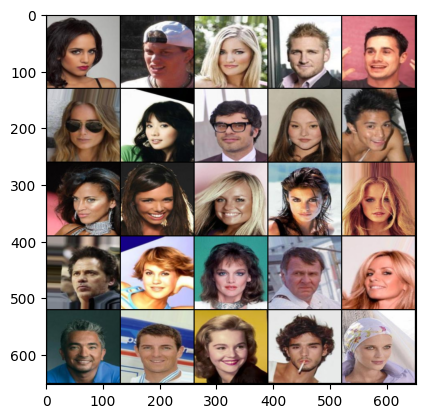

In [ ]:
#dataset
class Dataset(Dataset):
  def __init__(self, path, size ,lim=10000):
    self.sizes = [size,size]
    items, labels=[],[]
    for data in os.listdir(path)[:lim]:
      #path: './data/celeba/img_align_celeba'
      #data: '114568.jpg
      item = os.path.join(path,data)
      items.append(item)
      labels.append(data)

    self.items = items
    self.labels = labels

  def __len__(self):
    return len(self.items)

  def __getitem__(self,idx):
    data = PIL.Image.open(self.items[idx]).convert('RGB')
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # np>> width height channel
    data = np.transpose(data,(2,0,1)).astype(np.float32,copy=False) # torch >> channel width height
    data = torch.from_numpy(data).div(255) # bring intensities to range 0 & 1
    return data, self.labels[idx]

##Dataset
path='/content/data/celeba/img_align_celeba'
ds = Dataset(path=path, size=128,lim=8000)

##DataLoader
dataloader = DataLoader(ds,batch_size, shuffle=True)

##models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

# Initialization of parameters
#gen = gen.apply(init_weights)
#crit = crit.apply(init_weights)

#Optimizers
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr)
crit_opt = torch.optim.Adam(crit.parameters(),lr=lr)


x,y = next(iter(dataloader))
show(x)

In [ ]:
#gradient penalty calculation

def get_gp(real,fake,crit,alpha,gamma=10):
  mix_images = real*alpha + fake*(1-alpha)  #batch_size * channel * width * height
  mix_scores = crit(mix_images) #batch_size * 1

  gradient = torch.autograd.grad(inputs=mix_images, outputs=mix_scores,
                                 grad_outputs=torch.ones_like(mix_scores),
                                 retain_graph=True,
                                 create_graph=True
                                 )[0] #batch_size * channel * width * height

  gradient = gradient.view(len(gradient),-1) # 128* (channel * width * height )
  gradient_norm = gradient.norm(2, dim=1) # gradient is batch_size * () and we wanna compute the gradient of each batch
  gp = gamma * ((gradient_norm-1)**2).mean()

  return gp


Allowing the discriminator's gradient norm to grow too large can lead to unstable training dynamics and poor sample quality in GANs for several reasons:

Training Instability: Large gradients can cause sudden and drastic updates to the discriminator's parameters, leading to oscillations or divergence in the training process. This instability can hinder convergence and make it difficult to train the generator effectively.

Mode Collapse: When the discriminator becomes too sensitive to small changes in the input space, it may focus on only a few dominant modes of the data distribution, ignoring other modes. This phenomenon, known as mode collapse, results in poor diversity in the generated samples and a loss of information about the entire data distribution.

By constraining the discriminator's gradient norm, we can mitigate these issues and stabilize the training process:

Stabilizing Updates: Limiting the magnitude of the discriminator's gradients prevents large updates to its parameters, leading to smoother and more gradual updates during training. This stabilization helps avoid abrupt changes in the discriminator's decision boundary and promotes more stable training dynamics.

Encouraging Exploration: By preventing the discriminator from focusing excessively on specific regions of the input space, we encourage it to explore and learn from a more diverse set of samples. This exploration can help mitigate mode collapse and improve the coverage of the data distribution in the learned generator.

Now, regarding why we penalize the gradients of the discriminator's output with respect to interpolated points between real and generated samples:

Interpolated Points: Interpolating between real and generated samples allows us to create a smooth path in the input space, providing a more continuous and structured way to measure the discriminator's sensitivity to changes. By penalizing the gradients along this path, we encourage the discriminator to have a consistent response to variations in the input space, promoting smoother decision boundaries and better generalization.

Avoiding Bias: Penalizing only the gradients at generated samples may introduce bias, as the discriminator could learn to ignore certain regions of the input space that are not well represented by the generated samples. Interpolating between real and generated samples ensures that the penalty is applied more uniformly across the input space, reducing potential biases and encouraging the discriminator to learn from a more balanced set of samples.

Overall, penalizing the gradients of interpolated points helps enforce the Lipschitz constraint in a more robust and unbiased manner, leading to improved stability and diversity in the training process of Wasserstein GANs.

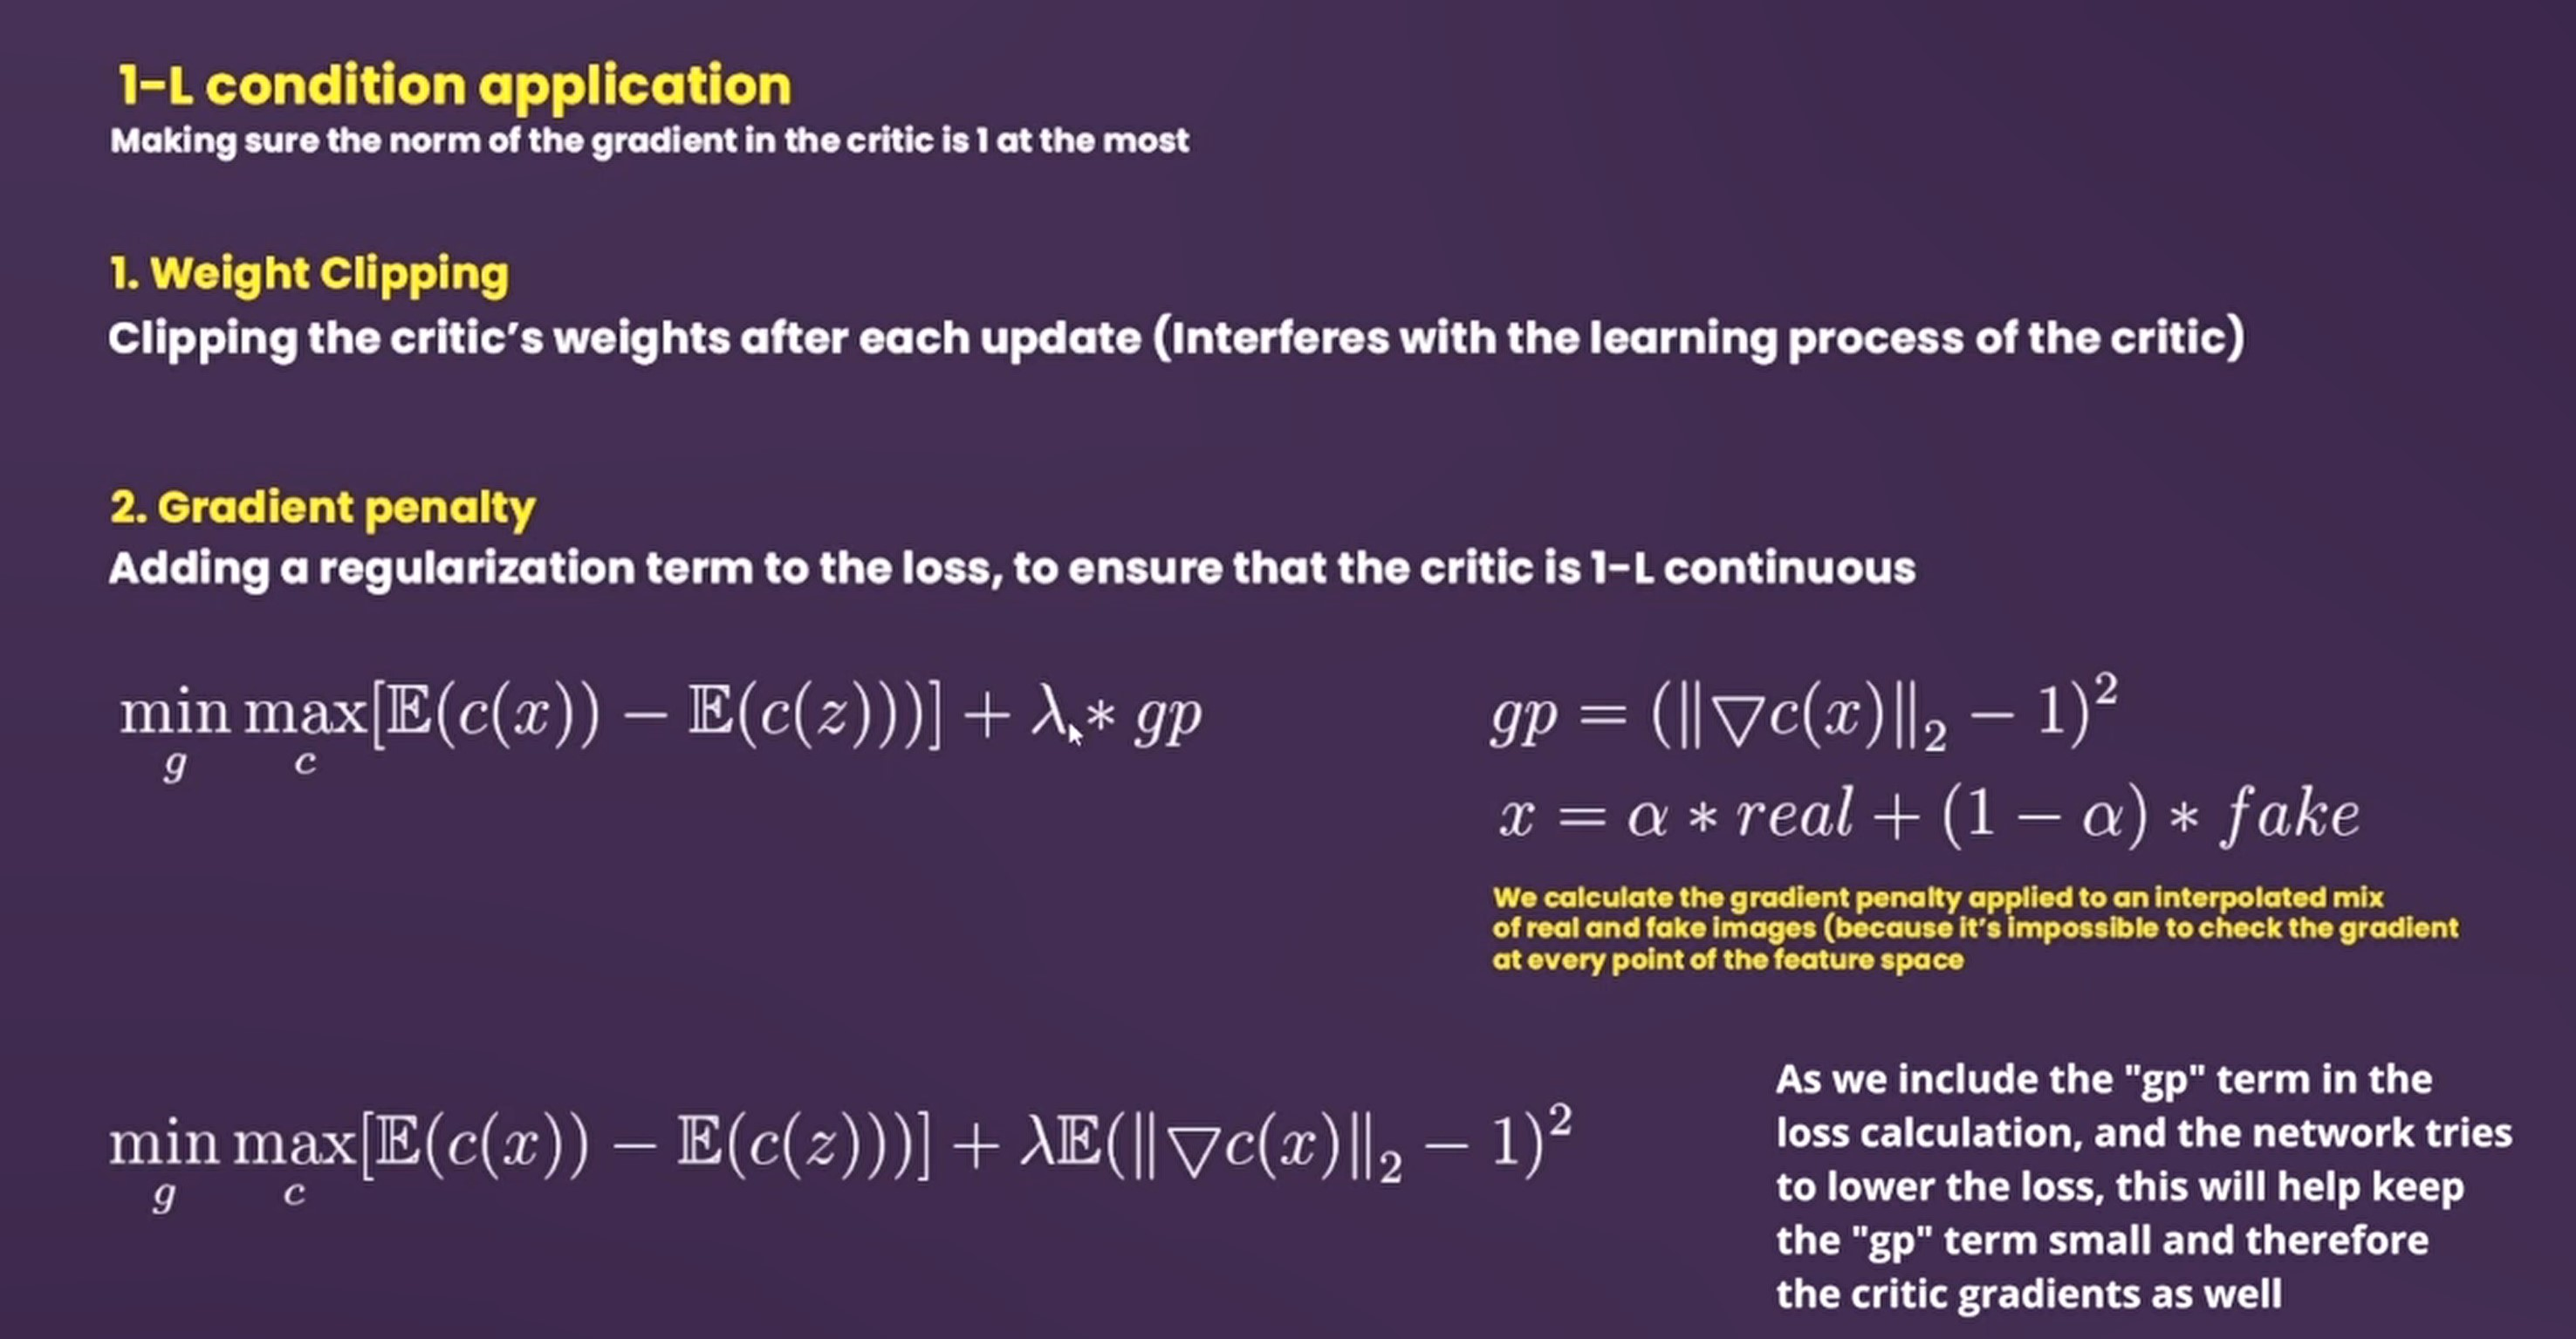

In [ ]:
root_path = '/content/data/'

def save_checkpoint(name):
  torch.save({
      'epoch':epoch,
      'model_state_dict': gen.state_dict(),
      'optimizer_state_dict': gen_opt.state_dict()
  },f'{root_path}G-{name}.pkl')

  torch.save({
      'epoch':epoch,
      'model_state_dict': crit.state_dict(),
      'optimizer_state_dict': crit_opt.state_dict()
  },f'{root_path}C-{name}.pkl')

  print('saved checkpoints')

def load_checkpoint(name):
  checkpoint = torch.load(f"{root_path}G-{name}.pkl")
  gen.load_state_dict(checkpoint["model_state_dict"])
  gen_opt.load_state_dict(checkpoint["optimizer_state_dict"])

  checkpoint = torch.load(f"{root_path}C-{name}.pkl")
  crit.load_state_dict(checkpoint["model_state_dict"])
  crit.load_state_dict(checkpoint["optimizer_state_dict"])

  print('loaded checkpoints')

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Saving checkpoint:  500 500
saved checkpoints


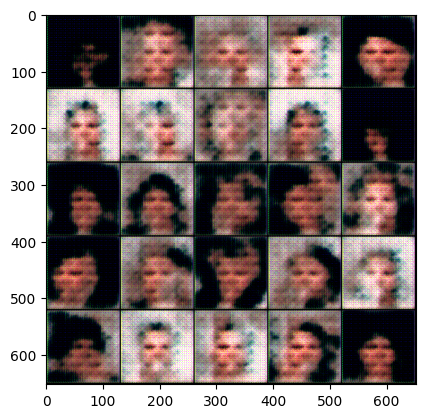

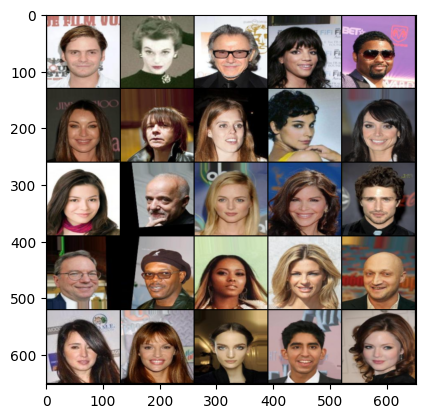

Epoch: 7: Step 500: Generator loss: 34.54647137153149, critic loss: -47.981263658082476


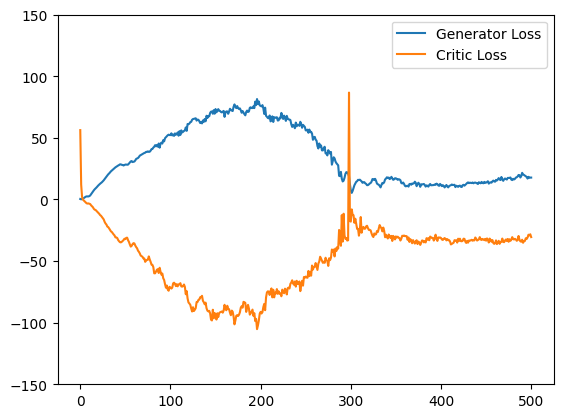

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Saving checkpoint:  1000 500
saved checkpoints


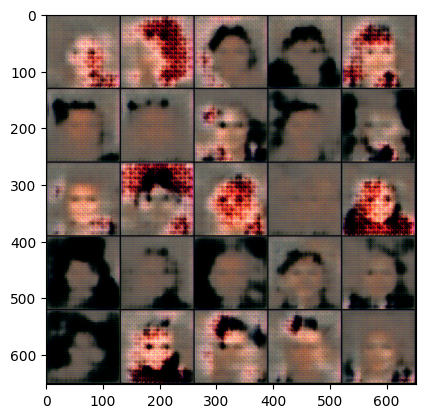

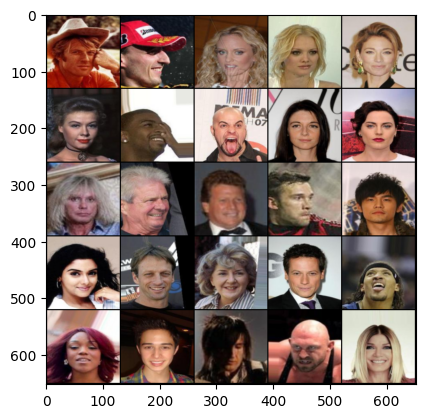

Epoch: 15: Step 1000: Generator loss: 29.518266929626463, critic loss: -30.66682512359618


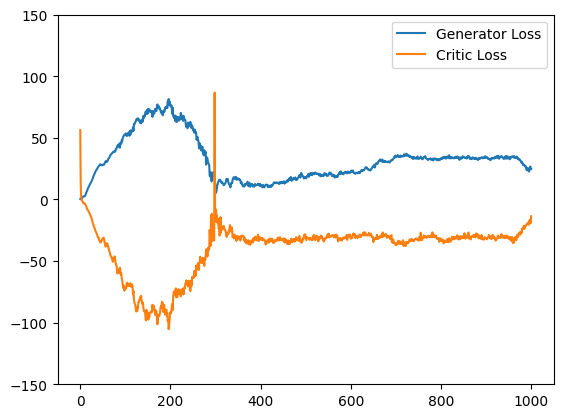

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Saving checkpoint:  1500 500
saved checkpoints


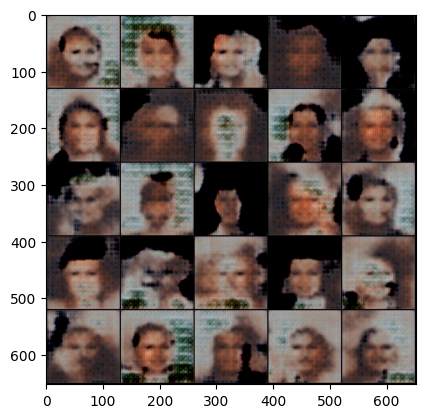

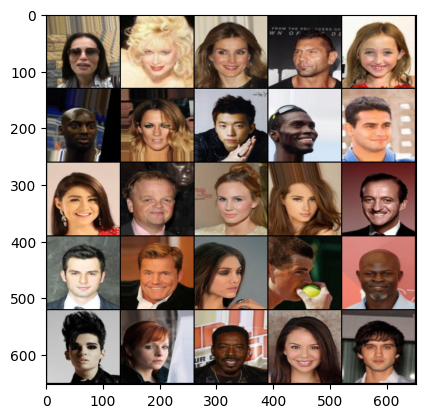

Epoch: 23: Step 1500: Generator loss: 16.330501438140868, critic loss: -13.034945188140865


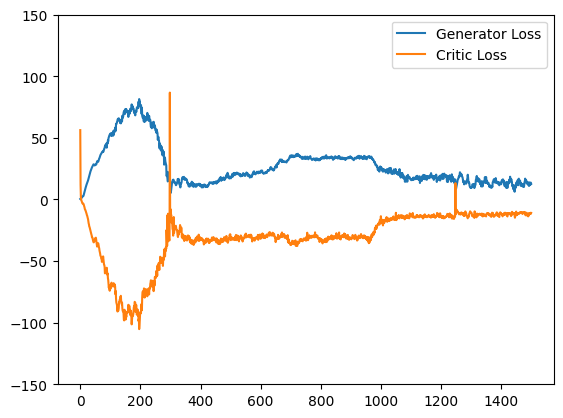

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Saving checkpoint:  2000 500
saved checkpoints


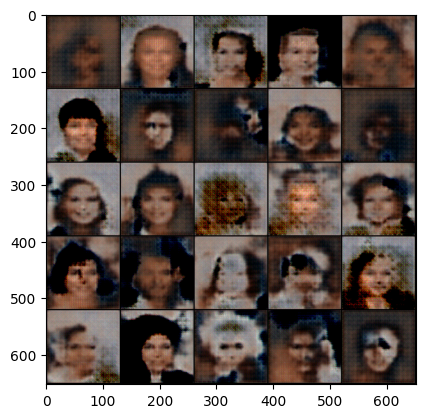

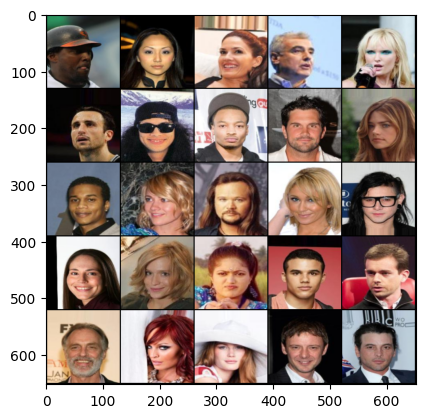

Epoch: 31: Step 2000: Generator loss: 11.759197017669678, critic loss: -10.64668967075347


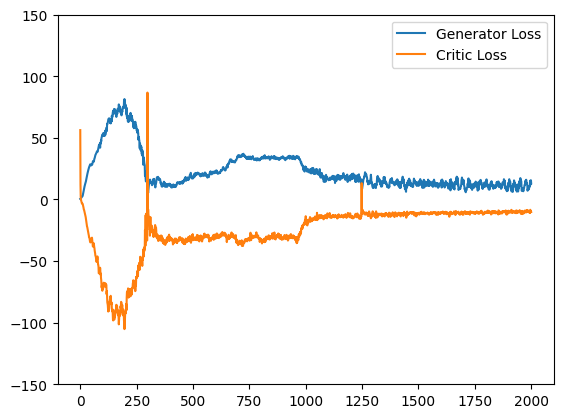

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Saving checkpoint:  2500 500
saved checkpoints


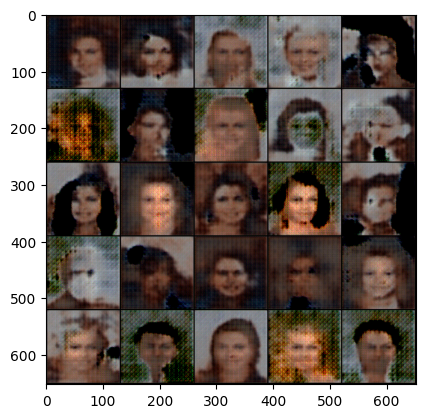

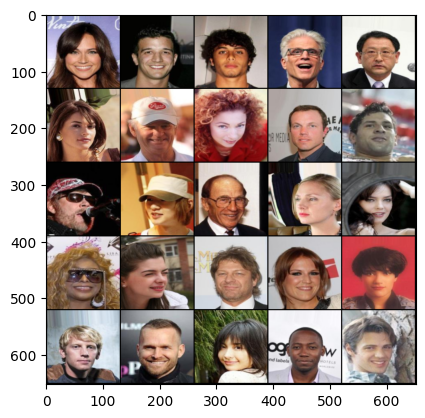

Epoch: 39: Step 2500: Generator loss: 12.26460012435913, critic loss: -9.512909867477422


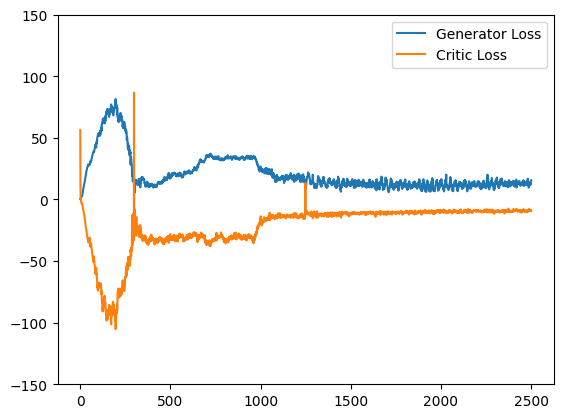

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Saving checkpoint:  3000 500
saved checkpoints


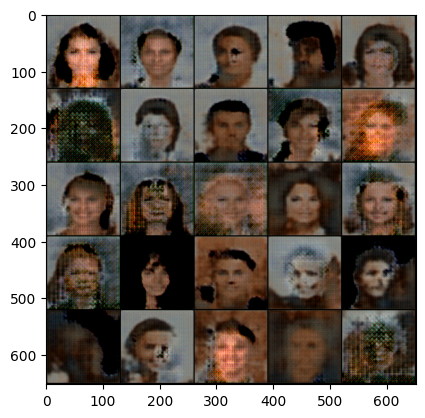

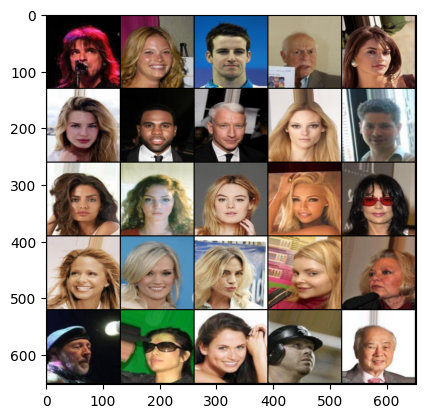

Epoch: 47: Step 3000: Generator loss: 13.22730396270752, critic loss: -8.948053666687008


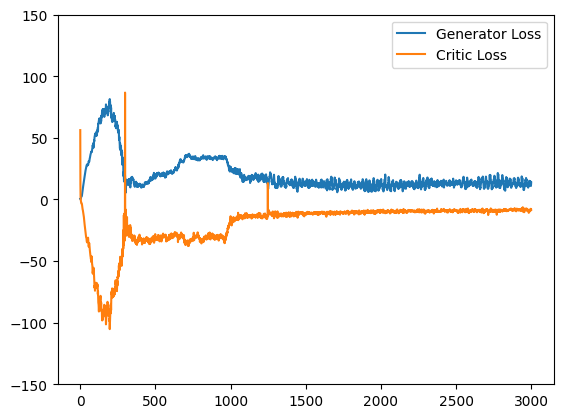

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
try:
  # training loop

  for epoch in range(epochs):
    for real,_ in tqdm(dataloader):
        cur_bs = len(real)
        real = real.to(device)
        ### CRITIC
        mean_crit_loss = 0
        for _ in range(crit_cycles):
            crit_opt.zero_grad()
            noise = gen_noise(z_dim, cur_bs)
            fake = gen(noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)
            alpha = torch.rand(len(real),1,1,1,device = device, requires_grad=True)
            gp = get_gp(real , fake.detach(), crit , alpha)
            crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp
            mean_crit_loss += crit_loss.item()/crit_cycles

            crit_loss.backward(retain_graph=True)
            crit_opt.step()


        crit_losses+=[mean_crit_loss]

        ### GENERATOR
        gen_opt.zero_grad()
        noise = gen_noise(z_dim , cur_bs)
        fake = gen(noise)
        crit_fake_pred = crit(fake)
        gen_loss = - crit_fake_pred.mean()
        gen_loss.backward()
        gen_opt.step()

        gen_losses += [gen_loss.item()]

        ### Stats

        if cur_step % save_step == 0 and cur_step > 0:
            print("Saving checkpoint: ", cur_step, save_step)
            save_checkpoint("latest")

            show(fake, name='fake')
            show(real, name='real')

            gen_mean=sum(gen_losses[-show_step:]) / show_step
            crit_mean = sum(crit_losses[-show_step:]) / show_step
            print(f"Epoch: {epoch}: Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")

            plt.plot(
                range(len(gen_losses)),
                torch.Tensor(gen_losses),
                label="Generator Loss"
            )

            plt.plot(
                range(len(crit_losses)),
                torch.Tensor(crit_losses),
                label="Critic Loss"
            )

            plt.ylim(-150,150)
            plt.legend()
            plt.show()

        cur_step+=1

except KeyboardInterrupt:
    # If training is interrupted, save the current state
    save_checkpoint("latest")

In [ ]:
#### Generate new faces
noise = gen_noise(z_dim , batch_size)
fake = gen(noise)
show(fake)

In [ ]:
plt.imshow(fake[16].detach().cpu().permute(1,2,0).squeeze().clip(0,1))

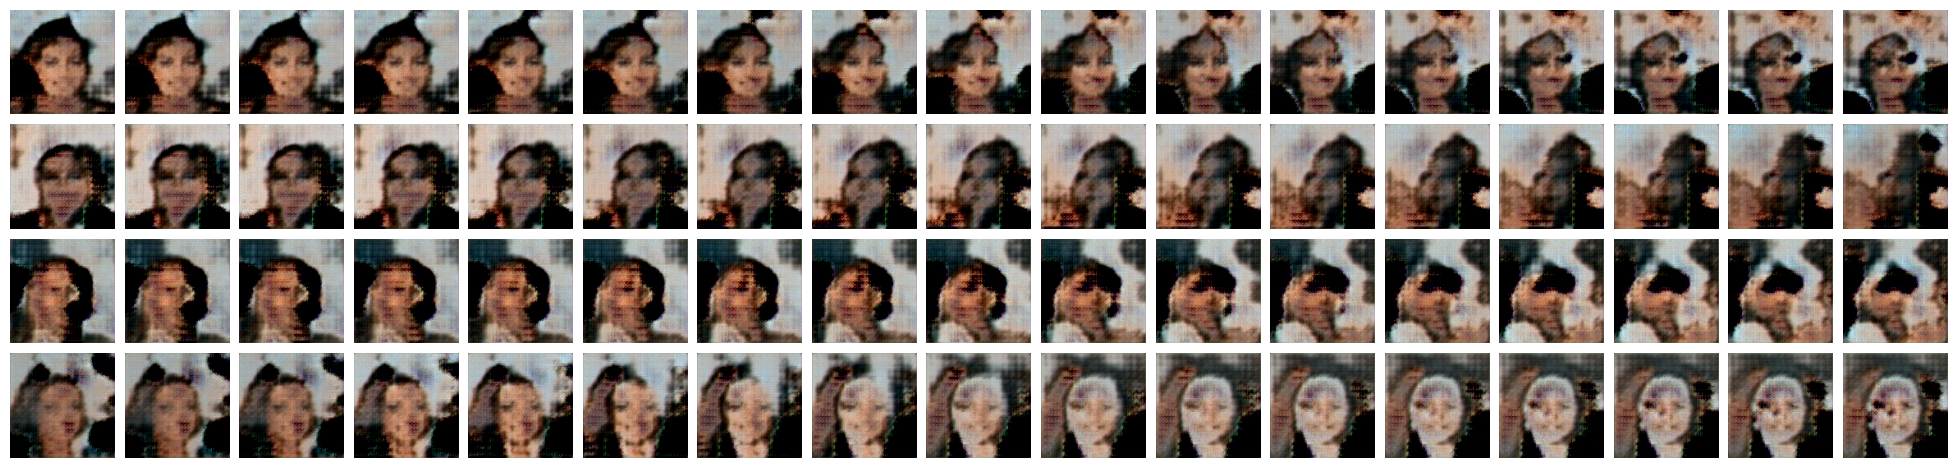

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

# MORPHING, interpolation between points in latent space
gen_set=[]
z_shape=[1,200,1,1]
rows=4
steps=17

for i in range(rows):
  z1,z2 = torch.randn(z_shape), torch.randn(z_shape)
  for alpha in np.linspace(0,1,steps):
    z=alpha*z1 + (1-alpha)*z2
    res=gen(z.cuda())[0]
    gen_set.append(res)

fig = plt.figure(figsize=(25,11))
grid=ImageGrid(fig, 111, nrows_ncols=(rows,steps), axes_pad=0.1)

for ax , img in zip (grid, gen_set):
  ax.axis('off')
  res=img.cpu().detach().permute(1,2,0)
  res=res-res.min()
  res=res/(res.max()-res.min())
  ax.imshow(res.clip(0,1.0))

plt.show()